In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


**FUNCIONS DE L'APP**

In [2]:
def carregar_dades(ciutat):
    # Població
    df_poblacio = pd.read_csv(f'dat/{ciutat}/poblacio.csv', skiprows=10, sep=";", decimal=",")
    df_poblacio.rename(columns={"Unnamed: 0":"Any", "Total":"Població"}, inplace=True)
    df_poblacio = df_poblacio.set_index("Any")
    df_poblacio = df_poblacio[['Població']]
    
    # Densitat
    df_densitat = pd.read_csv(f'dat/{ciutat}/densitat.csv', skiprows=6, sep=";", decimal=',')
    df_densitat.rename(columns={"Unnamed: 0":"Any", "Superfície (km²)":"Superfície", "Densitat (hab./km²)":"Densitat"}, inplace=True)
    df_densitat.set_index("Any", inplace=True)
    df_densitat = df_densitat[['Superfície', 'Densitat']]
    
    # Naixements
    df_naixements = pd.read_csv(f'dat/{ciutat}/naixements.csv', skiprows=8, sep=";")
    df_naixements.rename(columns={"Unnamed: 0":"Any", "Total":"Naixements"}, inplace=True)
    df_naixements.set_index("Any", inplace=True)
    df_naixements = df_naixements[['Naixements']]
    
    # Defuncions
    df_defuncions = pd.read_csv(f'dat/{ciutat}/defuncions.csv', skiprows=7, sep=";")
    df_defuncions.rename(columns={"Unnamed: 0":"Any", "Total":"Defuncions"}, inplace=True)
    df_defuncions.set_index("Any", inplace=True)
    df_defuncions = df_defuncions[['Defuncions']]

    # Aturats
    df_atur = pd.read_csv(f'dat/{ciutat}/atur.csv', skiprows=6, sep=";", decimal=',')
    df_atur.rename(columns={"Unnamed: 0":"Any", "Sexe. Total":"Aturats"}, inplace=True)
    df_atur = df_atur.set_index("Any")
    df_atur = df_atur[['Aturats']]

    # Pensionistes
    df_pensionistes = pd.read_csv(f'dat/{ciutat}/pensionistes.csv', skiprows=7, sep=";")
    df_pensionistes.rename(columns={'Unnamed: 0':'Any', 'Total':'Pensionistes'}, inplace=True)
    df_pensionistes = df_pensionistes.set_index("Any")
    df_pensionistes = df_pensionistes[['Pensionistes']]

    # Habitatges acabats
    df_habit = pd.read_csv(f'dat/{ciutat}/habitatges_construits.csv', skiprows=10, sep=";")
    noves_col = {
        'Unnamed: 0':'Any',
        'Habitatges iniciats amb protecció oficial':'HPO iniciats',
        'Habitatges acabats amb protecció oficial':'HPO acabats'
    }
    df_habit.rename(columns=noves_col, inplace=True)
    df_habit.set_index('Any', inplace=True)
    df_habit = df_habit[['HPO acabats', 'Habitatges acabats']]

    # Vehicles
    df_vehicles = pd.read_csv(f'dat/{ciutat}/vehicles.csv', skiprows=6, sep=";")
    df_vehicles.rename(columns={'Unnamed: 0':'Any'}, inplace=True)
    df_vehicles.set_index('Any', inplace=True)
    df_vehicles = df_vehicles[['Turismes', 'Motocicletes']]

    # Renta Familiar Disponible per Habitant
    df_rdf = pd.read_csv(f'dat/{ciutat}/rfd.csv', skiprows=6, sep=";")
    df_rdf.rename(columns={"Unnamed: 0":"Any",'Per habitant (€)':'RFDH' }, inplace=True)
    df_rdf = df_rdf.set_index("Any")
    df_rdf = df_rdf[['RFDH']]

    # Saldo de migracions internes
    df_migracionsint = pd.read_csv(f'dat/{ciutat}/migracions_internes.csv', skiprows=7, sep=";", decimal=",")
    df_migracionsint.rename(columns={"Unnamed: 0":"Any", 'Total':'Migracions internes'}, inplace=True)
    df_migracionsint = df_migracionsint.set_index("Any")
    df_migracionsint = df_migracionsint[['Migracions internes']]

    # Saldo de migracions externes
    df_migracionsext = pd.read_csv(f'dat/{ciutat}/migracions_externes.csv', skiprows=8, sep=";", decimal=",")
    df_migracionsext.rename(columns={"Unnamed: 0":"Any", 'Total':'Migracions externes'}, inplace=True)
    df_migracionsext = df_migracionsext.set_index("Any")
    df_migracionsext = df_migracionsext[['Migracions externes']]
    
    df = pd.concat([df_poblacio, df_densitat, df_naixements, df_defuncions, df_migracionsint, df_migracionsext,
                    df_atur, df_pensionistes, df_habit, df_vehicles, df_rdf], axis=1).sort_index(ascending=True)
    
    return df

def neteja_dades (df):
    df = df.drop(range(1975,2010))
    df.drop(2025, inplace=True)
    df['Població'] = df['Població'].fillna(round(df['Densitat']* df['Superfície'], 0)) # Omplim els NAN amb Densitat * Superfície
    df.loc[2015, 'Pensionistes'] = round((df['Pensionistes'][2016]+df['Pensionistes'][2014])/2, 0) # Omplim els NAN amb una interpolació lineal
    df.loc[2010, 'Pensionistes'] = round(2 * df.loc[2011, 'Pensionistes'] - df.loc[2012, 'Pensionistes'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2023, 'RFDH'] = round(2 * df.loc[2022, 'RFDH'] - df.loc[2021, 'RFDH'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2024, 'RFDH'] = round(2 * df.loc[2023, 'RFDH'] - df.loc[2022, 'RFDH'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2024, 'Migracions internes'] = round(2 * df.loc[2023, 'Migracions internes'] - df.loc[2022, 'Migracions internes'], 0) # Omplim els NAN amb una extrapolació lineal
    df.loc[2024, 'Migracions externes'] = round(2 * df.loc[2023, 'Migracions externes'] - df.loc[2022, 'Migracions externes'], 0) # Omplim els NAN amb una extrapolació lineal
    df.drop(columns='Superfície', inplace=True)
    return df

def afegir_taxes (df):
    df['Taxa natalitat'] = round(df.Naixements * 100 / df.Població, 2)
    df['Taxa mortalitat'] = round(df.Defuncions * 100 / df.Població, 2)
    df['Taxa atur'] = round(df.Aturats * 100 / df.Població, 2)
    df['Taxa dependència'] = round(df.Pensionistes * 100 / df.Població, 2)
    df['Taxa HPO'] = round(df['HPO acabats'] * 1000 / df.Població, 2)
    df['Taxa habitatges'] = round(df['Habitatges acabats'] * 1000 / df.Població, 2)
    df['Taxa turismes'] = round(df.Turismes * 100 / df.Població, 2)
    df['Taxa motocicletes'] = round(df.Motocicletes * 100 / df.Població, 2)
    return df


**CÀRREGA DE LES DADES I ANÀLISI EXPLORATORI**

In [3]:
ciutat = "Barcelona"
df = carregar_dades (ciutat)
df = neteja_dades (df)
df

,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,Turismes,Motocicletes,RFDH
Any,,,,,,,,,,,,,
2010,1619340.0,15977.7,14967.0,15305.0,-3939.0,49178.0,103546.5,339847.0,926.0,1672.0,596103.0,213441.0,20774.0
2011,1611013.0,15939.3,14775.0,15205.0,-1623.0,46366.0,107521.4,343344.0,1154.0,1839.0,590588.0,218033.0,20654.0
2012,1620941.0,15993.5,14584.0,16110.0,-4448.0,37564.0,112471.1,346841.0,1036.0,1077.0,584900.0,220960.0,19195.0
2013,1611820.0,15903.5,14018.0,15337.0,-1411.0,34593.0,110934.4,349618.0,172.0,666.0,572998.0,222407.0,19474.0
2014,1602384.0,15810.4,14065.0,15454.0,1149.0,40365.0,103465.9,350997.0,378.0,555.0,561556.0,223251.0,19691.0
2015,1604553.0,15831.8,14120.0,16003.0,-733.0,46164.0,93714.4,351134.0,316.0,836.0,561416.0,229377.0,20556.0
2016,1608749.0,15873.2,14087.0,15641.0,-5046.0,49496.0,82597.1,351272.0,263.0,1291.0,564416.0,236712.0,21132.0
2017,1620809.0,15992.2,13995.0,16249.0,-6683.0,58855.0,74824.5,350780.0,581.0,1039.0,565130.0,242336.0,21371.0
2018,1620343.0,15987.6,13328.0,15824.0,-12917.0,65134.0,70774.2,350399.0,244.0,1251.0,560632.0,247590.0,21538.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 2010 to 2024
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Població             15 non-null     float64
 1   Densitat             15 non-null     float64
 2   Naixements           15 non-null     float64
 3   Defuncions           15 non-null     float64
 4   Migracions internes  15 non-null     float64
 5   Migracions externes  15 non-null     float64
 6   Aturats              15 non-null     float64
 7   Pensionistes         15 non-null     float64
 8   HPO acabats          15 non-null     float64
 9   Habitatges acabats   15 non-null     float64
 10  Turismes             15 non-null     float64
 11  Motocicletes         15 non-null     float64
 12  RFDH                 15 non-null     float64
dtypes: float64(13)
memory usage: 2.2 KB


In [5]:
df.describe()

,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,Turismes,Motocicletes,RFDH
count,1.500000e+01,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,1.627050e+06,16076.586667,13297.133333,15961.733333,-8136.266667,61463.133333,85616.773333,346547.933333,531.600000,1348.800000,555213.666667,239396.866667,21449.000000
std,2.400965e+04,234.427524,1272.857352,1140.366261,6786.766561,23531.532644,18505.203847,4316.459023,327.674664,521.004003,28767.276647,16930.281281,1576.775824
min,1.602384e+06,15810.400000,11378.000000,15112.000000,-23387.000000,34593.000000,62150.800000,339847.000000,172.000000,555.000000,487185.000000,213441.000000,19195.000000
25%,1.611416e+06,15921.400000,12127.000000,15337.000000,-13081.000000,45051.000000,69783.350000,343595.000000,266.500000,1010.000000,541551.500000,222829.000000,20605.000000
50%,1.620343e+06,15992.200000,13995.000000,15641.000000,-6683.000000,49496.000000,82597.100000,346841.000000,380.000000,1251.000000,561416.000000,242336.000000,21132.000000
75%,1.632160e+06,16149.450000,14103.500000,16173.500000,-2781.000000,74448.000000,103506.200000,350589.500000,798.000000,1852.000000,569064.000000,253420.000000,22309.500000
max,1.686208e+06,16637.500000,14967.000000,19801.000000,1149.000000,104037.000000,112471.100000,351272.000000,1154.000000,2166.000000,596103.000000,265348.000000,24737.000000


In [6]:
df2 = afegir_taxes(df)
df2


,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,...,Motocicletes,RFDH,Taxa natalitat,Taxa mortalitat,Taxa atur,Taxa dependència,Taxa HPO,Taxa habitatges,Taxa turismes,Taxa motocicletes
Any,,,,,,,,,,,,,,,,,,,,,
2010,1619340.0,15977.7,14967.0,15305.0,-3939.0,49178.0,103546.5,339847.0,926.0,1672.0,...,213441.0,20774.0,0.92,0.95,6.39,20.99,0.57,1.03,36.81,13.18
2011,1611013.0,15939.3,14775.0,15205.0,-1623.0,46366.0,107521.4,343344.0,1154.0,1839.0,...,218033.0,20654.0,0.92,0.94,6.67,21.31,0.72,1.14,36.66,13.53
2012,1620941.0,15993.5,14584.0,16110.0,-4448.0,37564.0,112471.1,346841.0,1036.0,1077.0,...,220960.0,19195.0,0.90,0.99,6.94,21.40,0.64,0.66,36.08,13.63
2013,1611820.0,15903.5,14018.0,15337.0,-1411.0,34593.0,110934.4,349618.0,172.0,666.0,...,222407.0,19474.0,0.87,0.95,6.88,21.69,0.11,0.41,35.55,13.80
2014,1602384.0,15810.4,14065.0,15454.0,1149.0,40365.0,103465.9,350997.0,378.0,555.0,...,223251.0,19691.0,0.88,0.96,6.46,21.90,0.24,0.35,35.05,13.93
2015,1604553.0,15831.8,14120.0,16003.0,-733.0,46164.0,93714.4,351134.0,316.0,836.0,...,229377.0,20556.0,0.88,1.00,5.84,21.88,0.20,0.52,34.99,14.30
2016,1608749.0,15873.2,14087.0,15641.0,-5046.0,49496.0,82597.1,351272.0,263.0,1291.0,...,236712.0,21132.0,0.88,0.97,5.13,21.84,0.16,0.80,35.08,14.71
2017,1620809.0,15992.2,13995.0,16249.0,-6683.0,58855.0,74824.5,350780.0,581.0,1039.0,...,242336.0,21371.0,0.86,1.00,4.62,21.64,0.36,0.64,34.87,14.95
2018,1620343.0,15987.6,13328.0,15824.0,-12917.0,65134.0,70774.2,350399.0,244.0,1251.0,...,247590.0,21538.0,0.82,0.98,4.37,21.62,0.15,0.77,34.60,15.28


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 2010 to 2024
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Població             15 non-null     float64
 1   Densitat             15 non-null     float64
 2   Naixements           15 non-null     float64
 3   Defuncions           15 non-null     float64
 4   Migracions internes  15 non-null     float64
 5   Migracions externes  15 non-null     float64
 6   Aturats              15 non-null     float64
 7   Pensionistes         15 non-null     float64
 8   HPO acabats          15 non-null     float64
 9   Habitatges acabats   15 non-null     float64
 10  Turismes             15 non-null     float64
 11  Motocicletes         15 non-null     float64
 12  RFDH                 15 non-null     float64
 13  Taxa natalitat       15 non-null     float64
 14  Taxa mortalitat      15 non-null     float64
 15  Taxa atur            15 non-null     float

In [8]:
df2.describe()

,Població,Densitat,Naixements,Defuncions,Migracions internes,Migracions externes,Aturats,Pensionistes,HPO acabats,Habitatges acabats,...,Motocicletes,RFDH,Taxa natalitat,Taxa mortalitat,Taxa atur,Taxa dependència,Taxa HPO,Taxa habitatges,Taxa turismes,Taxa motocicletes
count,1.500000e+01,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,1.627050e+06,16076.586667,13297.133333,15961.733333,-8136.266667,61463.133333,85616.773333,346547.933333,531.600000,1348.800000,...,239396.866667,21449.000000,0.819333,0.980000,5.270667,21.304667,0.326667,0.826667,34.148667,14.706000
std,2.400965e+04,234.427524,1272.857352,1140.366261,6786.766561,23531.532644,18505.203847,4316.459023,327.674664,521.004003,...,16930.281281,1576.775824,0.085144,0.066117,1.177979,0.507766,0.201341,0.317055,2.130737,0.900157
min,1.602384e+06,15810.400000,11378.000000,15112.000000,-23387.000000,34593.000000,62150.800000,339847.000000,172.000000,555.000000,...,213441.000000,19195.000000,0.680000,0.910000,3.750000,20.180000,0.110000,0.350000,28.890000,13.180000
25%,1.611416e+06,15921.400000,12127.000000,15337.000000,-13081.000000,45051.000000,69783.350000,343595.000000,266.500000,1010.000000,...,222829.000000,20605.000000,0.740000,0.945000,4.285000,21.060000,0.160000,0.615000,32.915000,13.865000
50%,1.620343e+06,15992.200000,13995.000000,15641.000000,-6683.000000,49496.000000,82597.100000,346841.000000,380.000000,1251.000000,...,242336.000000,21132.000000,0.860000,0.970000,5.130000,21.400000,0.240000,0.770000,34.870000,14.950000
75%,1.632160e+06,16149.450000,14103.500000,16173.500000,-2781.000000,74448.000000,103506.200000,350589.500000,798.000000,1852.000000,...,253420.000000,22309.500000,0.880000,1.000000,6.425000,21.665000,0.475000,1.125000,35.315000,15.470000
max,1.686208e+06,16637.500000,14967.000000,19801.000000,1149.000000,104037.000000,112471.100000,351272.000000,1154.000000,2166.000000,...,265348.000000,24737.000000,0.920000,1.190000,6.940000,21.900000,0.720000,1.330000,36.810000,15.800000


**ANÀLISI DESCRIPTIU**

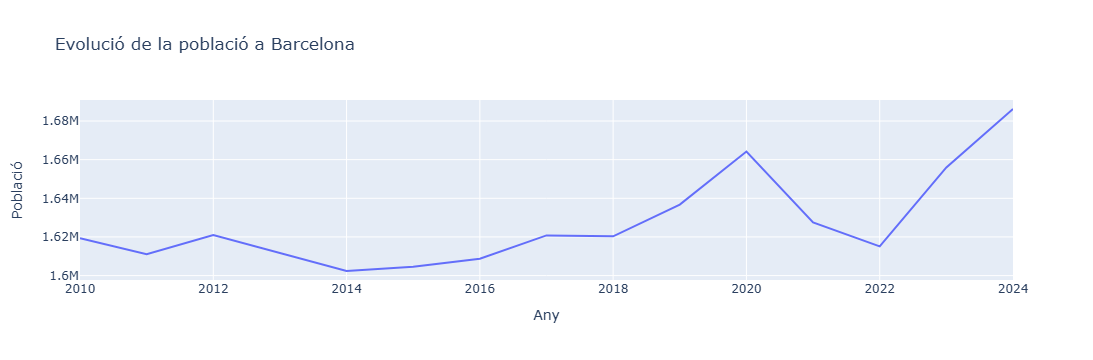

In [9]:
fig = px.line(df2, 
              y='Població',
              title=f'Evolució de la població a {ciutat}'
             )
fig.show()

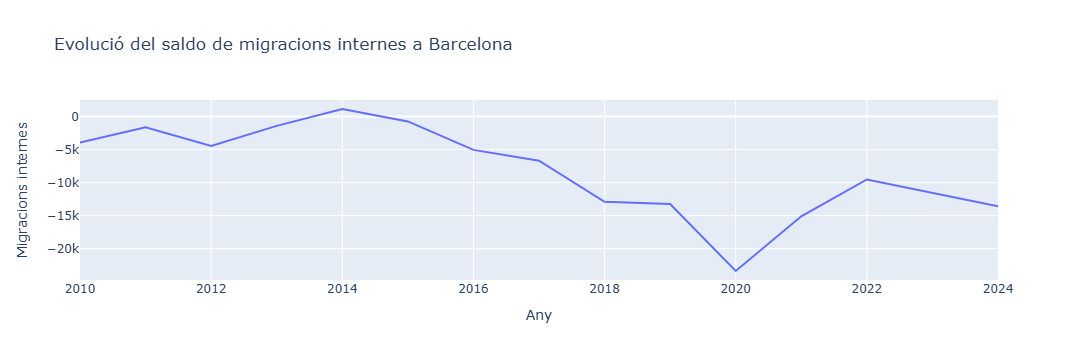

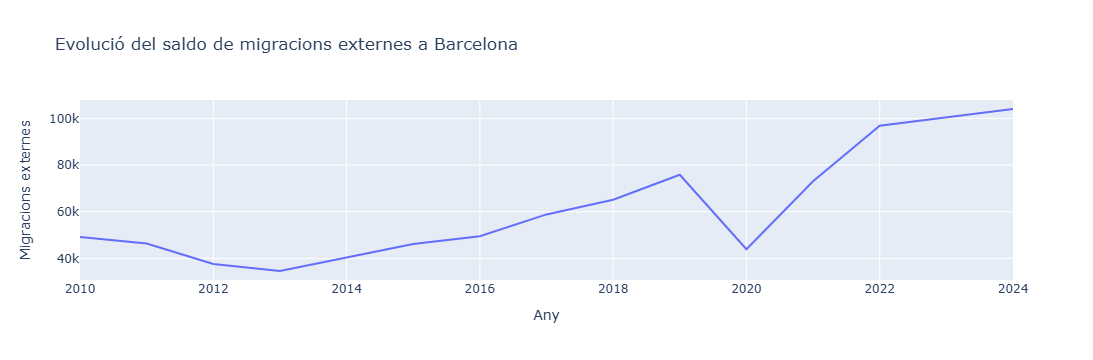

In [10]:
fig = px.line(df2, 
              y='Migracions internes',
              title=f'Evolució del saldo de migracions internes a {ciutat}'
             )
fig2 = px.line(df2,
               y='Migracions externes',
               title=f'Evolució del saldo de migracions externes a {ciutat}'
              )
fig.show()
fig2.show()

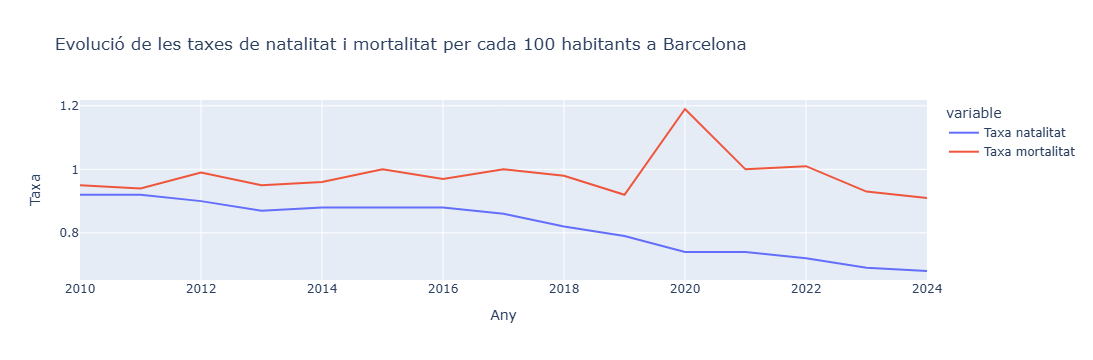

In [11]:
fig = px.line(df2, 
              y=['Taxa natalitat', 'Taxa mortalitat'],
              title=f'Evolució de les taxes de natalitat i mortalitat per cada 100 habitants a {ciutat}',
              labels={'value':'Taxa'}
             )
fig.show()

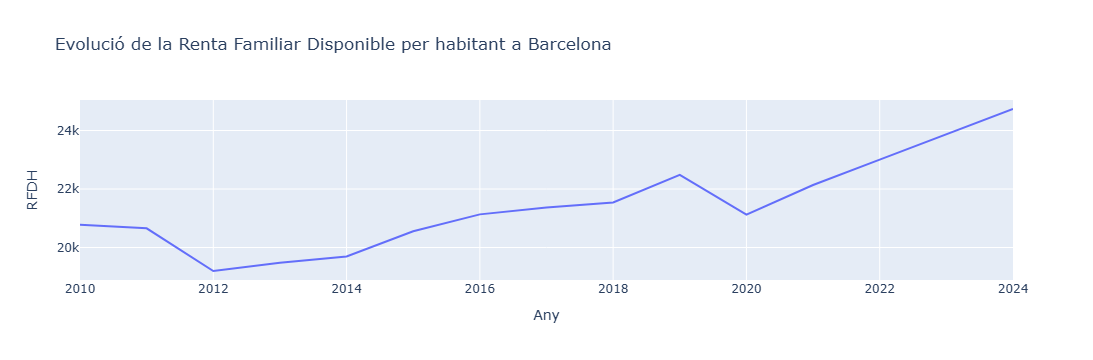

In [12]:
fig = px.line(df2, 
              y='RFDH',
              title=f'Evolució de la Renta Familiar Disponible per habitant a {ciutat}'
             )
fig.show()

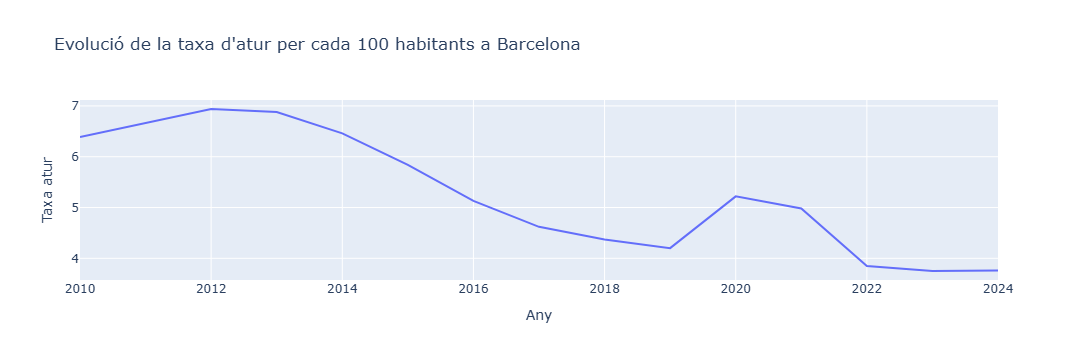

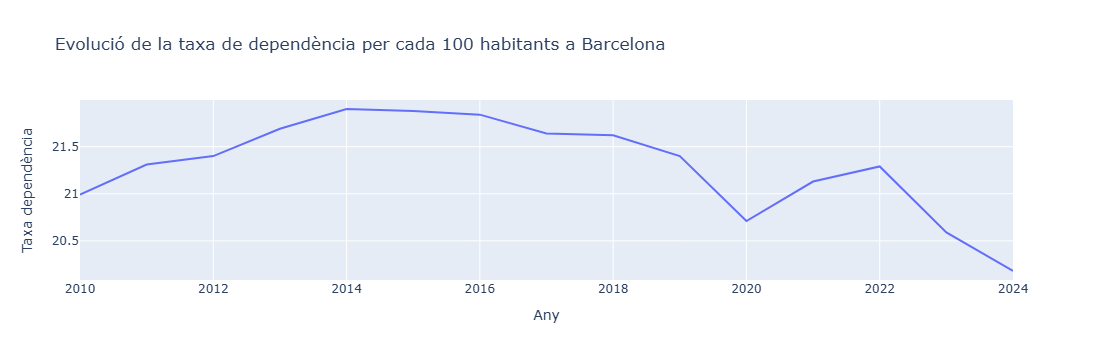

In [13]:
fig = px.line(df2, y='Taxa atur',
              title=f"Evolució de la taxa d'atur per cada 100 habitants a {ciutat}",
              labels={'value':"Taxa d'atur"}
             )
fig2 = px.line(df2, y='Taxa dependència',
               title=f"Evolució de la taxa de dependència per cada 100 habitants a {ciutat}",
               labels={'value':"Taxa de dependència"}
              )
fig.show()
fig2.show()

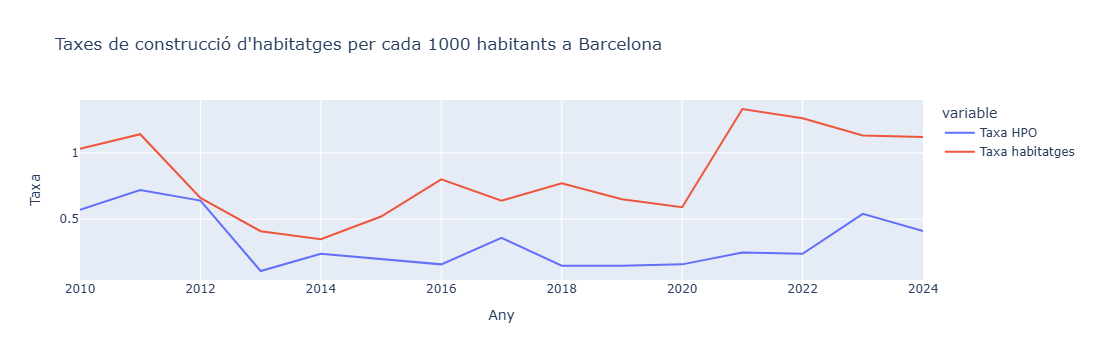

In [14]:
fig = px.line(df2,
              y=['Taxa HPO', 'Taxa habitatges'],
              title=f"Taxes de construcció d'habitatges per cada 1000 habitants a {ciutat}",
              labels={'value':'Taxa'}
             )
fig.show()

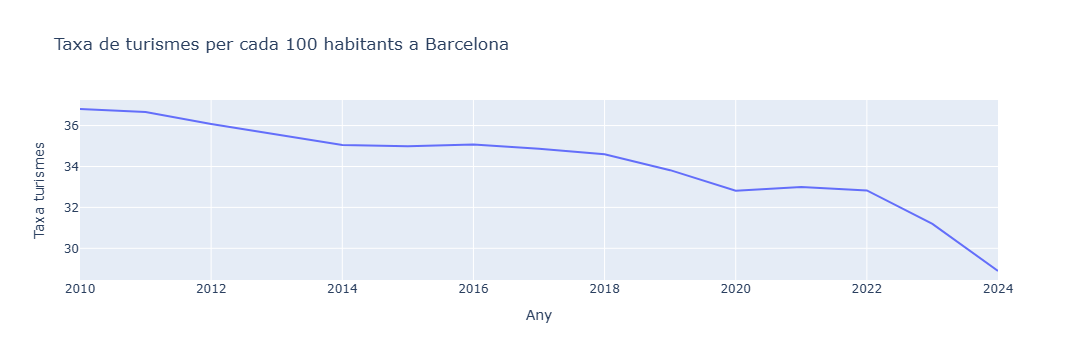

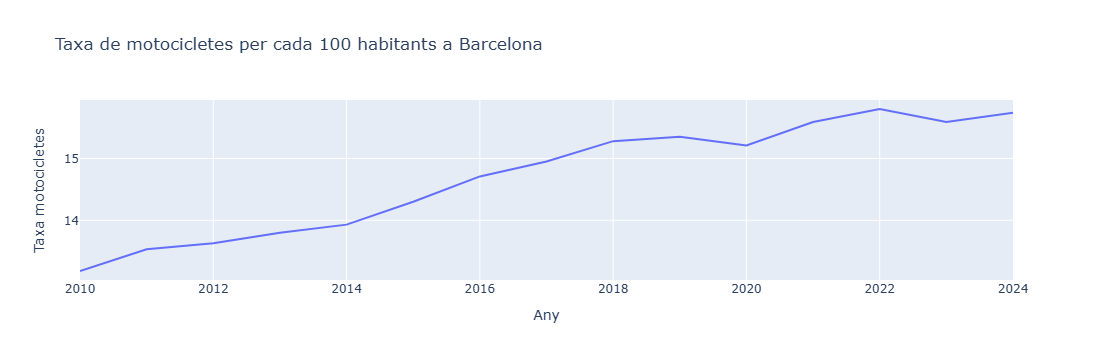

In [15]:
fig = px.line(df2, 
              y='Taxa turismes',
              title=f'Taxa de turismes per cada 100 habitants a {ciutat}'
             )
fig2 = px.line(df2, 
               y='Taxa motocicletes',
               title=f'Taxa de motocicletes per cada 100 habitants a {ciutat}'
              )
fig.show()
fig2.show()

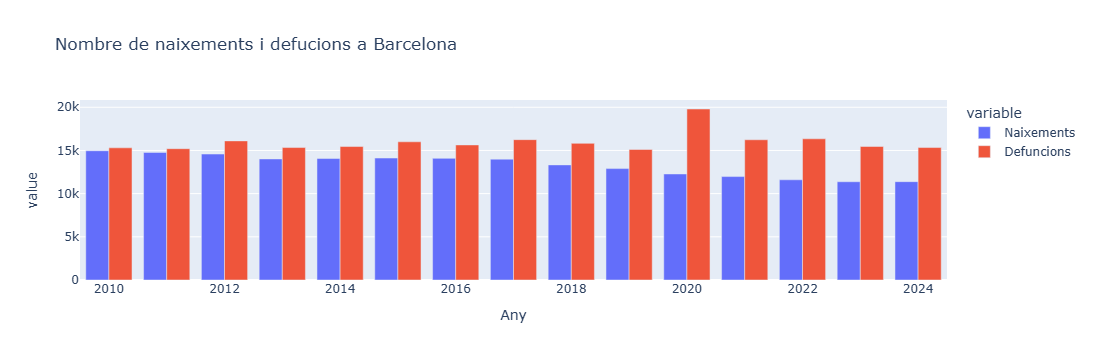

In [16]:
fig = px.bar(df2,
             y= ['Naixements', 'Defuncions'],
             barmode='group',
             title=f'Nombre de naixements i defucions a {ciutat}'
            )
fig.show()

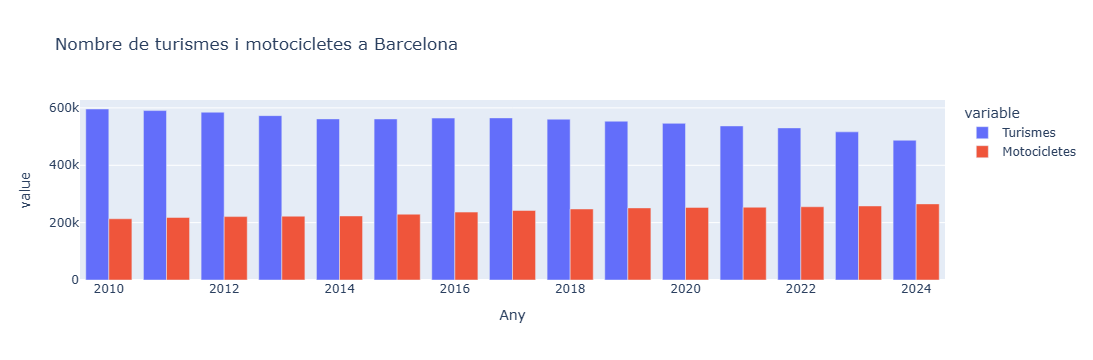

In [17]:
fig = px.bar(df2,
             y= ['Turismes', 'Motocicletes'],
             barmode='group',
             title=f'Nombre de turismes i motocicletes a {ciutat}'
            )
fig.show()

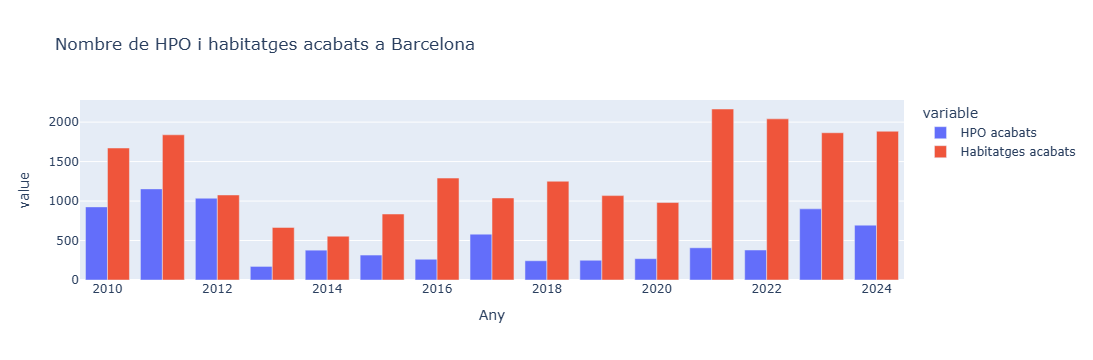

In [18]:
fig = px.bar(df2,
             y= ['HPO acabats', 'Habitatges acabats'],
             barmode='group',
             title=f"Nombre de HPO i habitatges acabats a {ciutat}"
            )
fig.show()

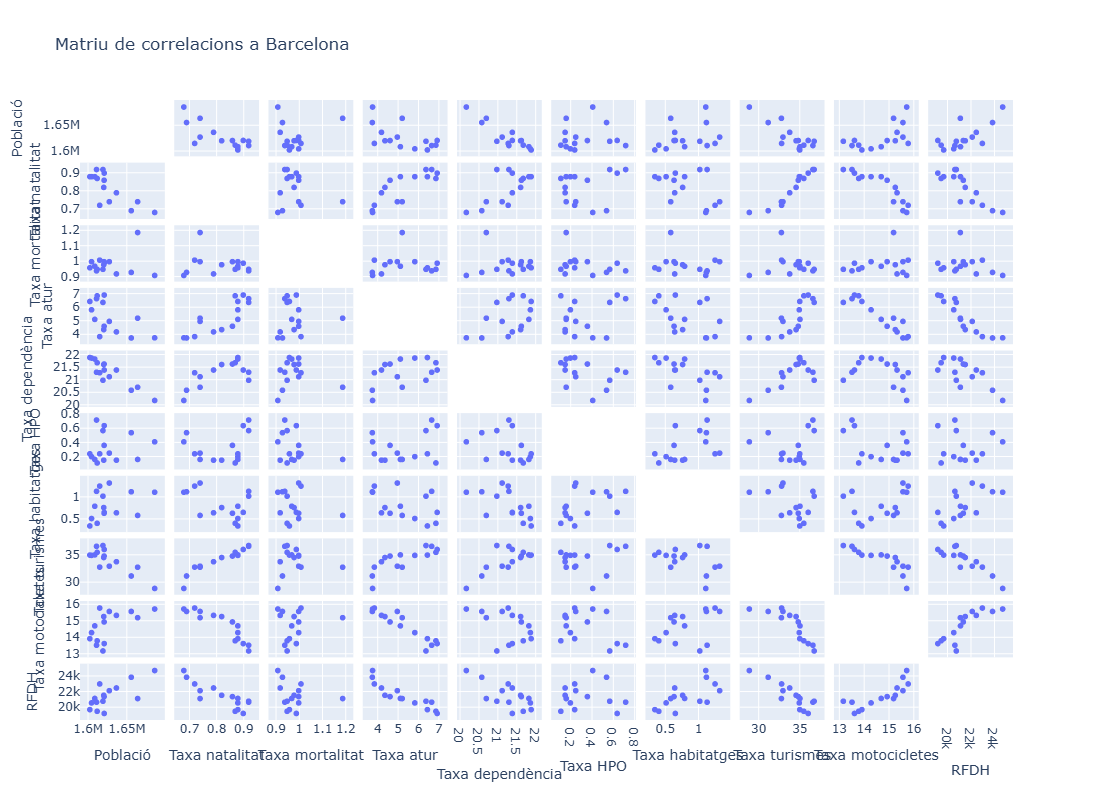

In [19]:
fig = px.scatter_matrix(
    df2,
    dimensions = ['Població', 'Taxa natalitat', 'Taxa mortalitat', 'Taxa atur', 'Taxa dependència',
                  'Taxa HPO', 'Taxa habitatges', 'Taxa turismes', 'Taxa motocicletes', 'RFDH'],
    height=800,
    width=800,
    title=f'Matriu de correlacions a {ciutat}'
)
fig.update_traces(diagonal_visible=False)  # Ocultar histogramas en la diagonal
fig.update_layout(
    dragmode='select',     # Permitir selección de puntos
    hovermode='closest',   # Mostrar datos al pasar el ratón
    font=dict(size=12)
)
fig.show()

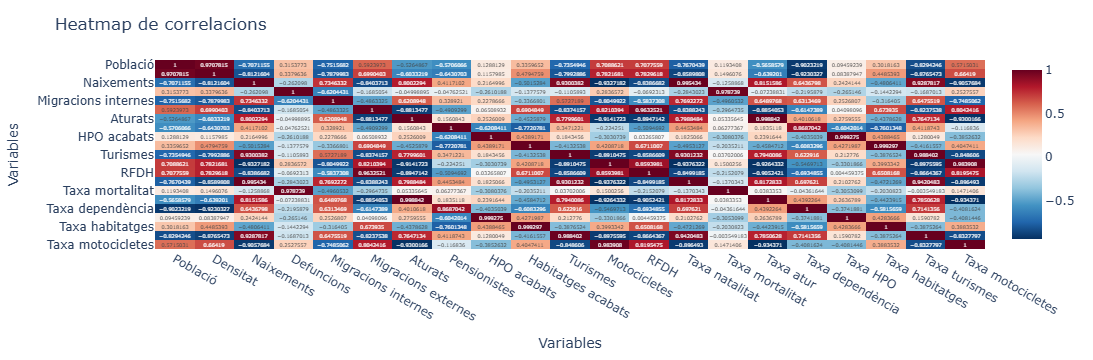

In [20]:
corr = df2.corr()
fig = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    aspect='auto'
)
fig.update_layout( title='Heatmap de correlacions', xaxis_title='Variables', yaxis_title='Variables' )
fig.show()

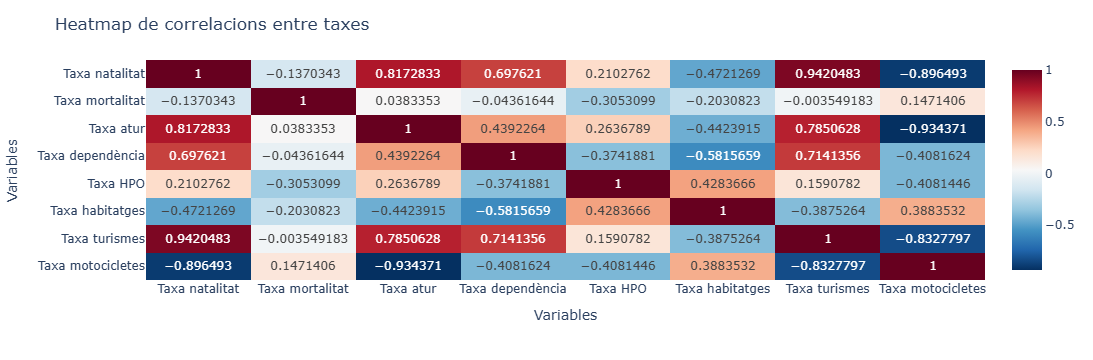

In [21]:
cols = [c for c in df.columns if 'Taxa' in c]
corr = df2[cols].corr()
fig = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    aspect='auto'
)
fig.update_layout( title='Heatmap de correlacions entre taxes', xaxis_title='Variables', yaxis_title='Variables' )
fig.show()

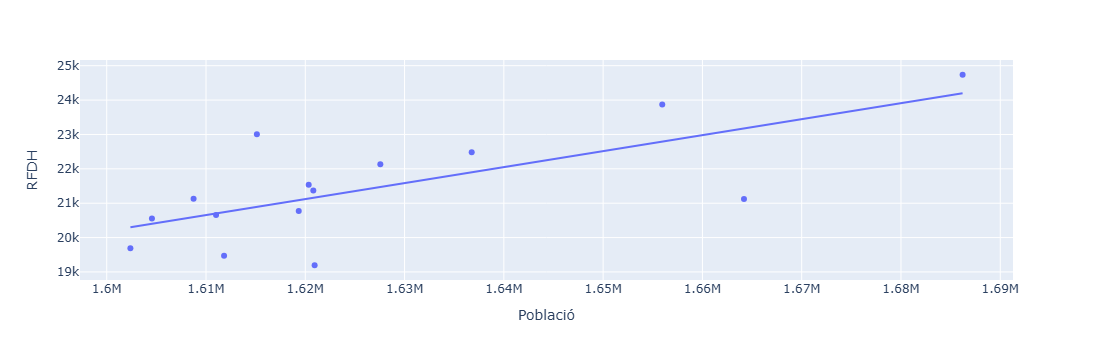

In [22]:
fig = px.scatter(df2, x='Població', y='RFDH', trendline='ols')
fig.show()

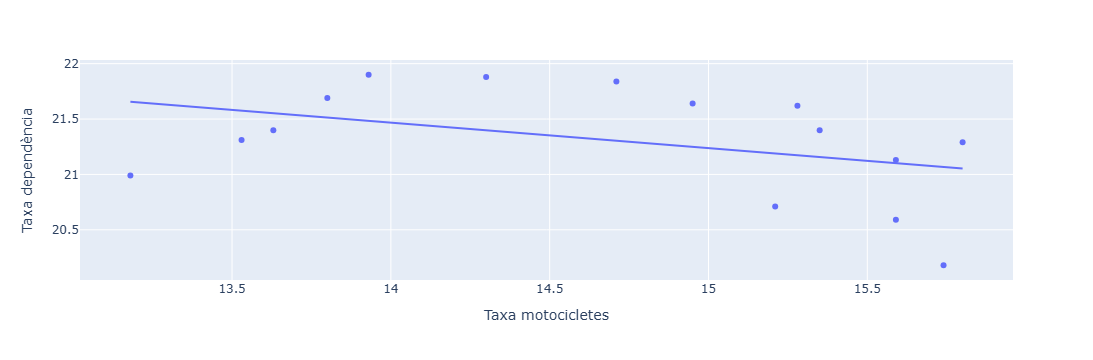

In [23]:
fig = px.scatter(df2, x='Taxa motocicletes', y='Taxa dependència', trendline='ols')
fig.show()

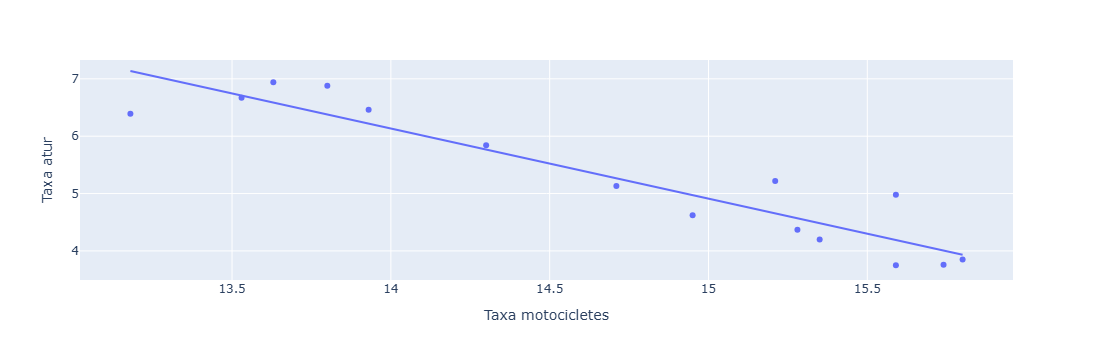

In [24]:
fig = px.scatter(df2, x='Taxa motocicletes', y='Taxa atur', trendline='ols')
fig.show()

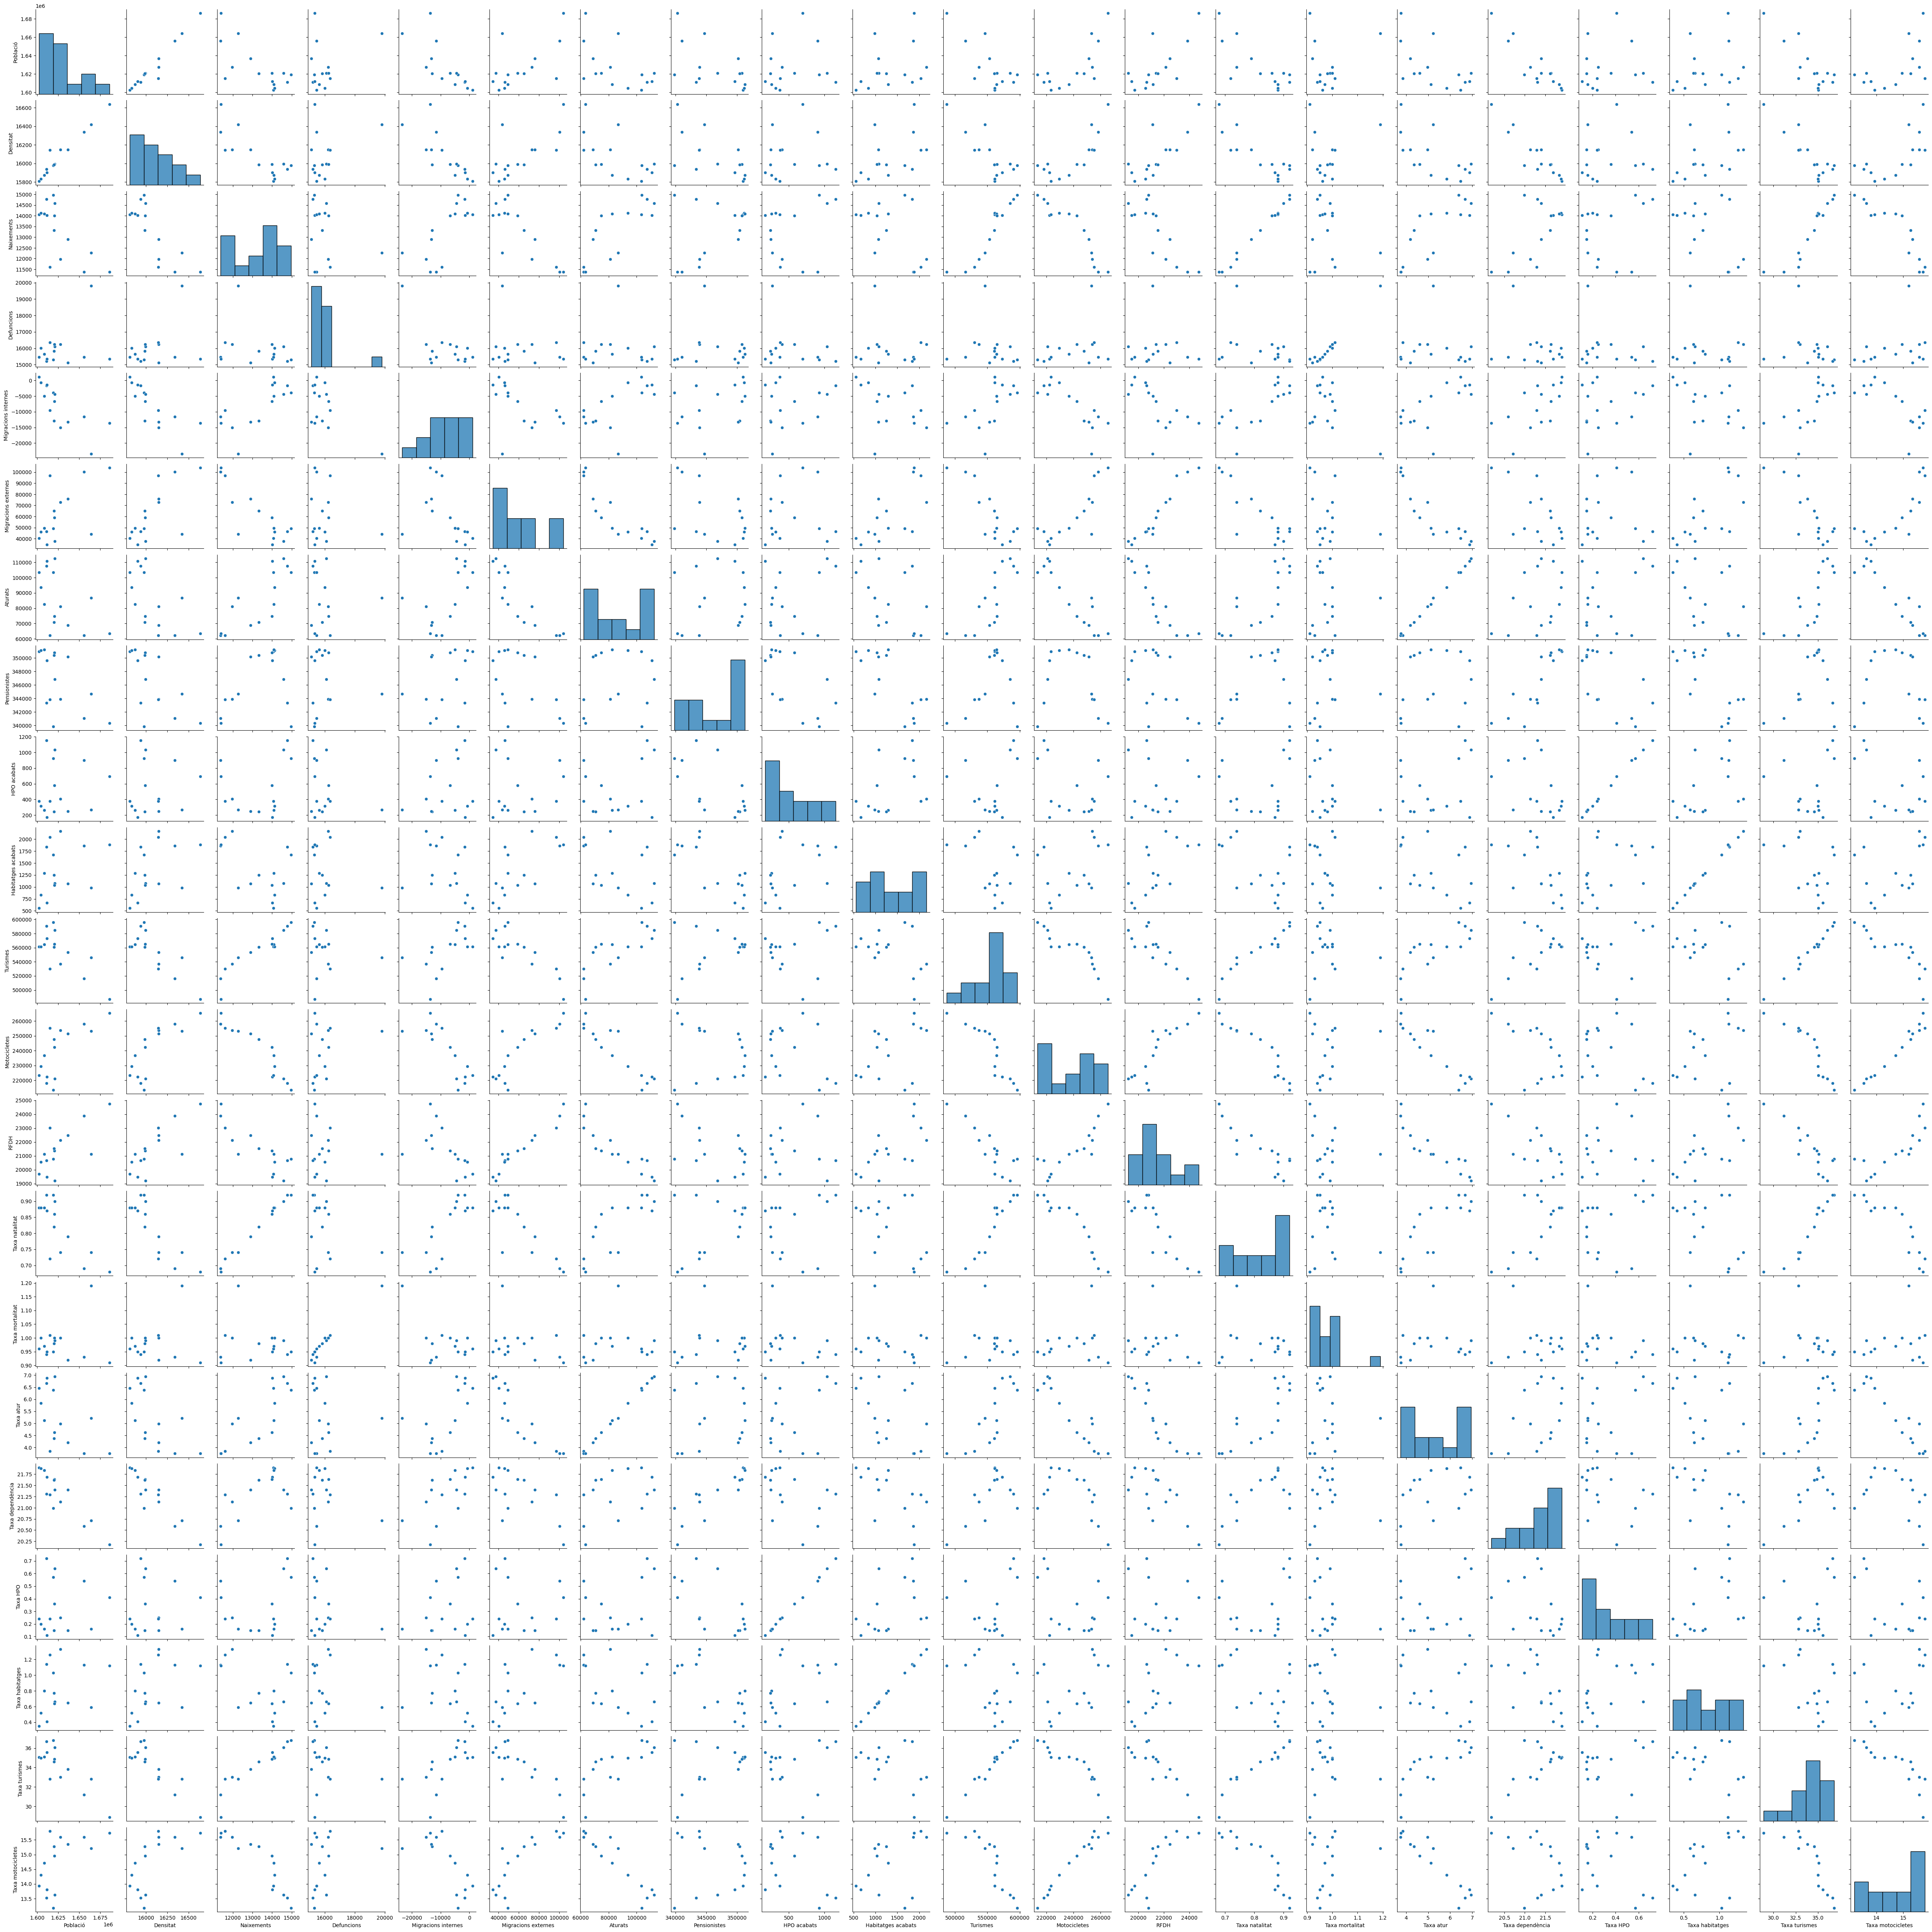

In [25]:
sns.pairplot(df2)
plt.show()

**ANÀLISI PREDICTIU**

              Variable  Coeficient
0           Naixements   -2.328143
1           Defuncions   -1.552899
2  Migracions internes   -2.201196
3  Migracions externes    0.177174
[1653995.27480866]
r2 = 0.6345139134089017


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_20292\113110075.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



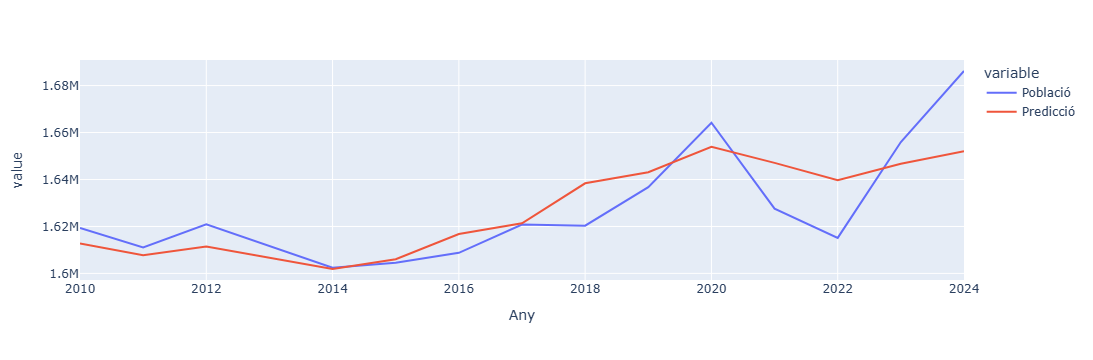

In [26]:
# Predicció de Població segons Naixements, Defuncions i Migracions

X = df2[["Naixements", "Defuncions", "Migracions internes", "Migracions externes"]]
y = df2[["Població"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['Població']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()


In [27]:
# Predicció de Població segons Naixements, Defuncions i Migracions amb Random Forest

# 1. Seleccionar variables
X = df2[["Naixements", "Defuncions", "Migracions internes", "Migracions externes"]]
y = df2["Població"]

# 2. Dividir en entrenament i test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Crear i entrenar el model
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42
)

model.fit(X_train, y_train)

# 4. Avaluació
preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R2:", r2)

# 5. Importància de les variables
importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))


RMSE: 15225.106060488122
R2: -3.5773521650702422
Migracions internes    0.469098
Naixements             0.319239
Migracions externes    0.127919
Defuncions             0.083744
dtype: float64


              Variable  Coeficient
0           Naixements    4.769482
1           Defuncions    6.455616
2              Aturats    2.224439
3         Pensionistes    2.652972
4                 RFDH   29.400046
5  Migracions internes   -2.226903
6  Migracions externes    0.444638
[-325293.64691188]
r2 = 0.8408792110068994


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_20292\1570774157.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



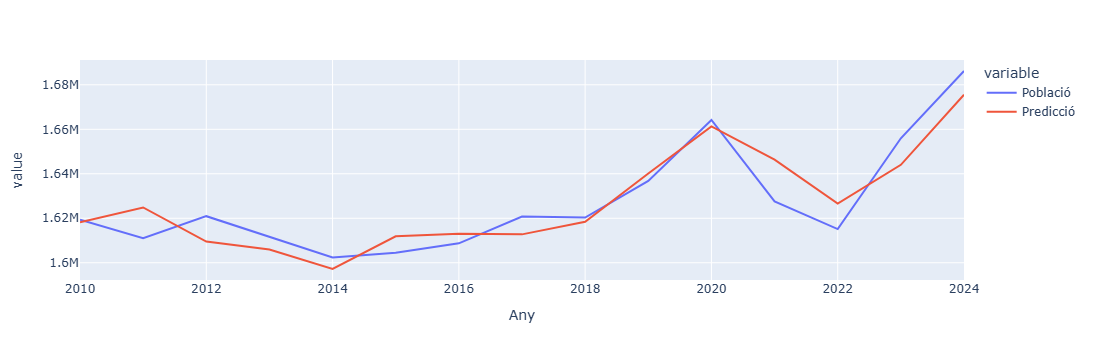

In [28]:
# Predicció de Població segons Naixements, Defuncions, Aturats, Pensionistes, RFDH i Migracions

X = df2[["Naixements", "Defuncions", "Aturats", "Pensionistes", "RFDH", "Migracions internes", "Migracions externes"]]
y = df2[["Població"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['Població']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()

              Variable  Coeficient
0             Població    0.113715
1                 RFDH   -6.996294
2           Naixements   -4.773154
3           Defuncions   -4.043213
4  Migracions internes    0.573639
5  Migracions externes   -0.636882
6         Pensionistes   -1.744534
[827042.47458703]
r2 = 0.9863066631891952


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_20292\2175888387.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



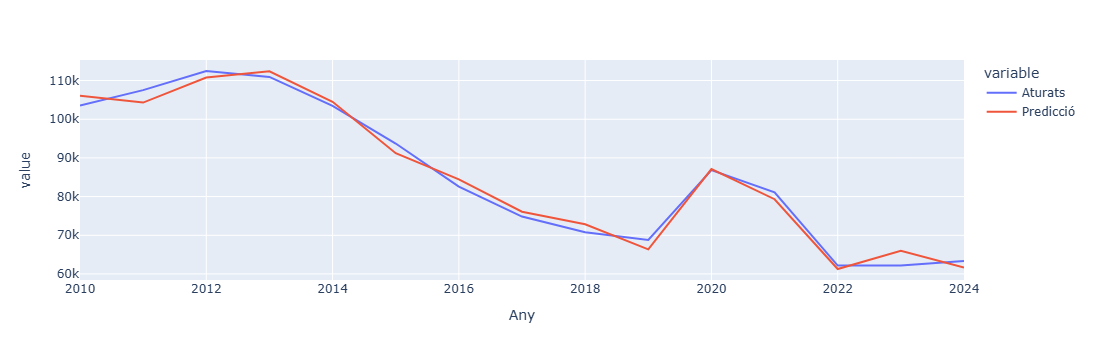

In [29]:
# Predicció del nombre d'Aturats segons Població, RFDH, Naixements, Defuncions i Migracions

X = df2[["Població", "RFDH", "Naixements", "Defuncions", "Migracions internes", "Migracions externes", "Pensionistes"]]
y = df2[["Aturats"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['Aturats']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()



              Variable  Coeficient
0             Població    0.015254
1           Naixements   -0.227829
2           Defuncions   -0.265393
3  Migracions internes    0.032327
4  Migracions externes   -0.012276
5              Aturats   -0.071010
6         Pensionistes   -0.115425
[50992.1521286]
r2 = 0.9808571248612655


C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_20292\791505936.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



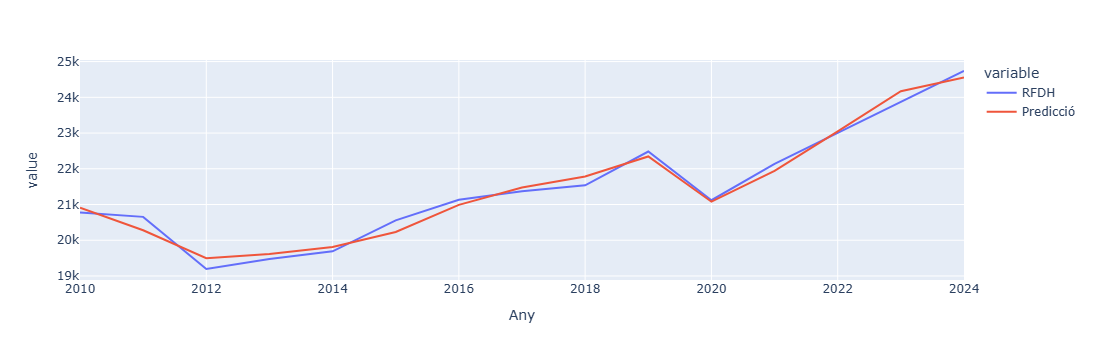

In [30]:
# Predicció del nombre de RFDH segons Població, Naixements, Defuncions, Migracions, Aturats i Pensionistes

X = df2[["Població", "Naixements", "Defuncions", "Migracions internes", "Migracions externes", "Aturats", "Pensionistes"]]
y = df2[["RFDH"]]

model = LinearRegression().fit(X, y)
pred = model.predict(X)

coeficients = pd.DataFrame({
    "Variable": X.columns,
    "Coeficient": model.coef_[0]
})
intercept = model.intercept_

r2 = model.score(X, y)

print(coeficients)
print(intercept)
print('r2 =', r2)

df_plot = df2[['RFDH']]
df_plot['Predicció'] = pred

fig = px.line(df_plot)
fig.show()

                               SARIMAX Results                                
Dep. Variable:               Població   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -158.565
Date:                Thu, 05 Feb 2026   AIC                            323.131
Time:                        10:32:19   BIC                            325.048
Sample:                    01-01-2010   HQIC                           322.953
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4618      6.954     -0.066      0.947     -14.091      13.168
ma.L1          0.4556      7.053      0.065      0.948     -13.367      14.278
sigma2      5.022e+08   5.27e-08   9.53e+15      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



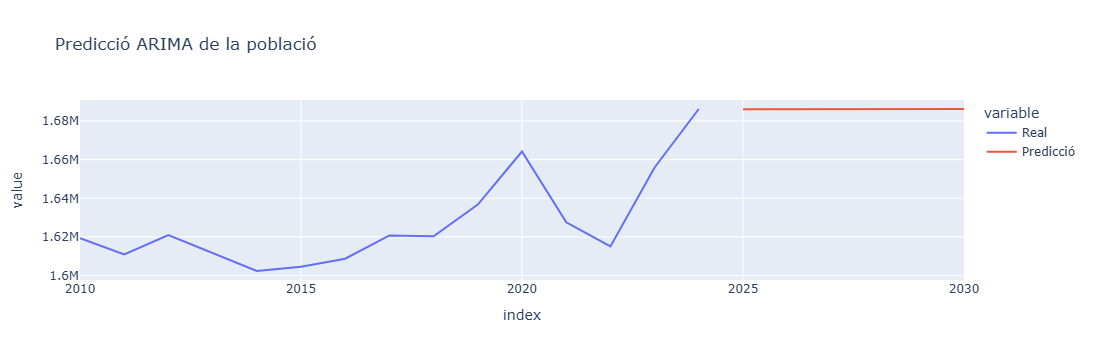

In [31]:
# Prediccions de Població al futur amb ARIMA

s = df2["Població"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de la població")
fig.show()



                               SARIMAX Results                                
Dep. Variable:                   RFDH   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -113.712
Date:                Thu, 05 Feb 2026   AIC                            233.425
Time:                        10:32:20   BIC                            235.342
Sample:                    01-01-2010   HQIC                           233.247
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4252      2.788      0.153      0.879      -5.039       5.889
ma.L1         -0.4687      2.609     -0.180      0.857      -5.582       4.644
sigma2      7.098e+05   6.33e+05      1.122      0.2

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



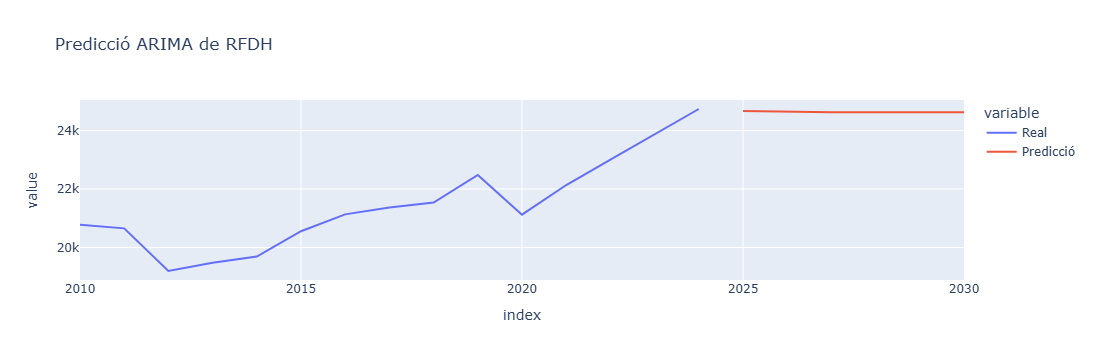

In [32]:
# Prediccions de RFDH al futur amb ARIMA

s = df2["RFDH"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de RFDH")
fig.show()

                               SARIMAX Results                                
Dep. Variable:                Aturats   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -146.969
Date:                Thu, 05 Feb 2026   AIC                            299.938
Time:                        10:32:21   BIC                            301.855
Sample:                    01-01-2010   HQIC                           299.760
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1978      2.508      0.079      0.937      -4.718       5.114
ma.L1         -0.1372      2.542     -0.054      0.957      -5.120       4.845
sigma2      8.428e+07   2.38e-07   3.54e+14      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



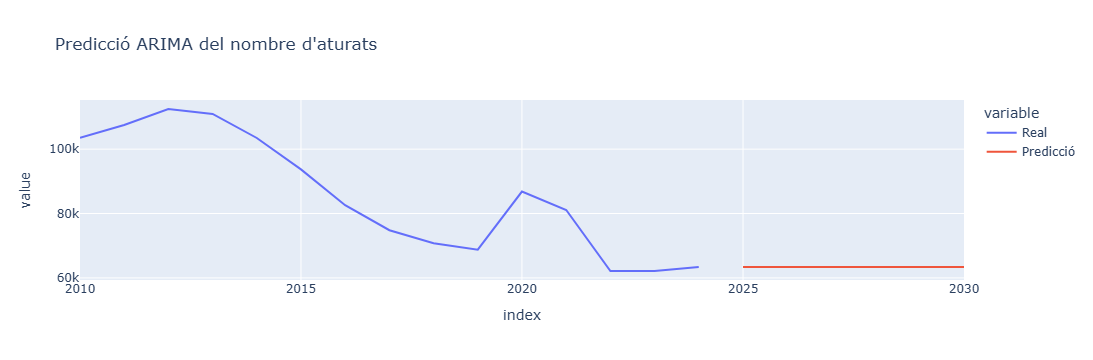

In [33]:
# Prediccions de Aturats al futur amb ARIMA

s = df2["Aturats"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA del nombre d'aturats")
fig.show()

                               SARIMAX Results                                
Dep. Variable:     Habitatges acabats   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -104.405
Date:                Thu, 05 Feb 2026   AIC                            214.809
Time:                        10:32:22   BIC                            216.726
Sample:                    01-01-2010   HQIC                           214.632
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7190      0.578      1.243      0.214      -0.414       1.853
ma.L1         -0.9975      0.364     -2.737      0.006      -1.712      -0.283
sigma2      1.631e+05   2.31e-06   7.05e+10      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



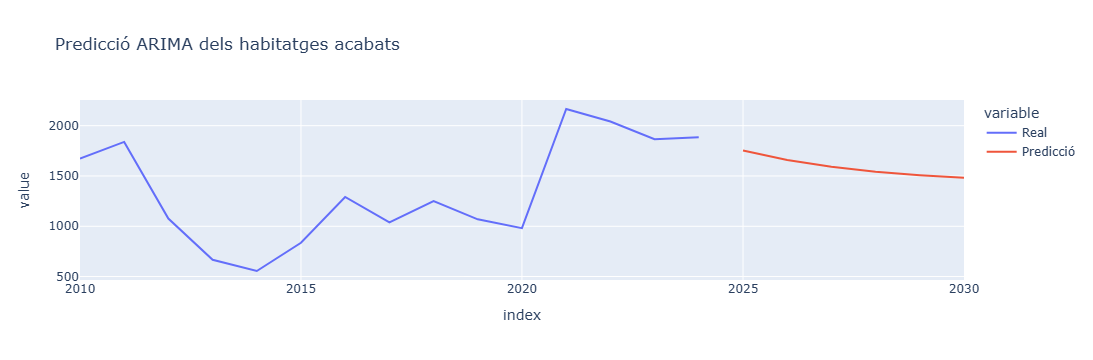

In [34]:
# Prediccions de Habitatges acabats al futur amb ARIMA

s = df2["Habitatges acabats"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA dels habitatges acabats")
fig.show()

                               SARIMAX Results                                
Dep. Variable:             Naixements   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -100.753
Date:                Thu, 05 Feb 2026   AIC                            207.507
Time:                        10:32:25   BIC                            209.424
Sample:                    01-01-2010   HQIC                           207.330
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4837      0.612      0.790      0.430      -0.717       1.684
ma.L1         -0.2247      0.689     -0.326      0.744      -1.575       1.125
sigma2      7.711e+04   2.84e+04      2.712      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



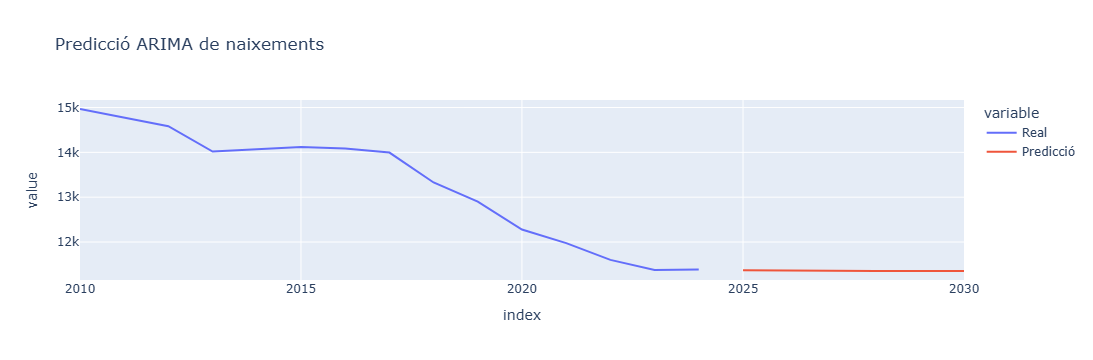

In [35]:
# Prediccions de Naixements acabats al futur amb ARIMA

s = df2["Naixements"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de naixements")
fig.show()

                               SARIMAX Results                                
Dep. Variable:             Defuncions   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -122.934
Date:                Thu, 05 Feb 2026   AIC                            251.867
Time:                        10:32:26   BIC                            253.785
Sample:                    01-01-2010   HQIC                           251.690
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4291      2.318     -0.185      0.853      -4.972       4.113
ma.L1          0.2974      2.393      0.124      0.901      -4.393       4.987
sigma2      2.403e+06   7.12e+05      3.376      0.0

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\Alumne_mati1\Thonny\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.



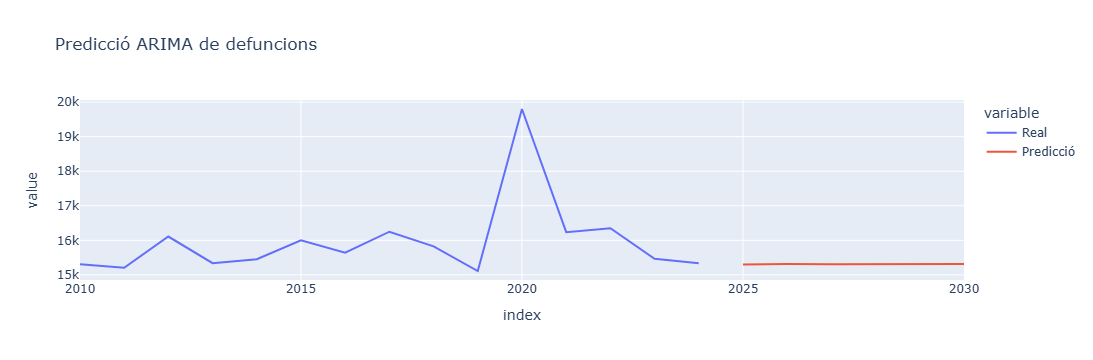

In [36]:
# Prediccions de Defuncions al futur amb ARIMA

s = df2["Defuncions"]        # variable a predir
s.index = pd.to_datetime(s.index, format="%Y")   # convertir anys a dates

model = ARIMA(s, order=(1,1,1))   # ARIMA(p,d,q)
fit = model.fit()
print(fit.summary())

pred = fit.forecast(steps=6)
print(pred)

s_real = s.rename("Real")
s_pred = pred.rename("Predicció")
df_plot = pd.concat([s_real, s_pred], axis=1)

fig = px.line(df_plot, title="Predicció ARIMA de defuncions")
fig.show()